## Compute Offset

**Author**: Ivan Zvonkov

**Last modified**: Mar 6, 2024

**Description**: 
Computes crop field coordinates by using a distance offset. Specifically the notebook:
1. Loads coordinates of photos labeled as crop
2. Computes car driving direction by using prior photo coordinate
3. Computes the passenger facing direction by rotating the driving direction 90 degrees.
4. Computes the coordinate 20 meters into that direction.
5. Converts generated coordinate to pixel centroid.

## 1. Load crop coordinates

In [ ]:
!pip install utm -q

In [2]:
import folium
import pandas as pd
import math
import numpy as np
import pyproj
import utm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from datetime import datetime, timedelta
from google.cloud import firestore
from google.cloud.firestore_v1.base_query import FieldFilter

In [3]:
df = pd.read_csv("../data/street2sat-v2-points-in-field.csv")

In [4]:
df.iloc[0]

index                                                                      0
pixel_height                                                          2028.0
mapbox_field_coord_lat                                             -0.138847
focal_length                                                             3.0
bing_img_segmentation      gs://street2sat-satellite-imgs-predictions/bin...
mapbox_field_coord_lon                                             35.952528
input_img                  gs://street2sat-uploaded/KENYA_v2/2021-07-05-T...
results                    {'background': 0.6317, 'sunflower': 0.0, 'whea...
name                                         KENYA_v2-2021-07-05-T1-GPAE2277
bing_field_coord_lon                                               35.952222
time                                               2021-07-05 15:38:56+00:00
mapbox_img_source          gs://street2sat-satellite-imgs-with-arrow/mapb...
bing_img_source            gs://street2sat-satellite-imgs-with-arrow/bing...

## 2. Get Prior Coordinate

In [5]:
# Obtain current point, lat, lon, time
# 1 because prior point (1) will be used to compute direction
row = df.iloc[0]
lat1, lon1 = row["road_lat"], row["road_lon"]
time1 = datetime.fromisoformat(row["time"])

In [6]:
coord1 = eval(row["coord"])
coord1

[-0.1387873, 35.952341799972224]

In [ ]:
!gcloud auth application-default login

In [13]:
db = firestore.Client()
coll = db.collection("street2sat-v2")

In [7]:
before_time_interval = time1 - timedelta(seconds=10)

In [15]:
photo_references = (
    coll.where(filter=FieldFilter("time", ">", before_time_interval))
    .where(filter=FieldFilter("time", "<", time1))
    .order_by("time", direction="DESCENDING")
    .limit(1)
    .get()
)

In [8]:
prev_photo_record = photo_references[0].to_dict()

NameError: name 'photo_references' is not defined

In [17]:
time0 = prev_photo_record["time"]
assert time1 > time0, "Not prior point"

In [9]:
coord0 = prev_photo_record["coord"]
coord0

NameError: name 'prev_photo_record' is not defined

In [10]:
# no Wifi solution
coord0 = [-0.1387766, 35.9523378]

## 3 Convert WGS84 coordinates to UTM coordinates
Though WGS84 coordinates can be used to compute the passenger side direction, they cannot be used to compute a 5 meter offset.

UTM coordinates can be used for both purposes so for simplicity, we convert now.

In [11]:
# Output format: EASTING, NORTHING, ZONE_NUMBER, ZONE_LETTER (bigger more east, bigger more north)
utm_coord1 = utm.from_latlon(coord1[0], coord1[1])
print(utm_coord1)
utm_coord0 = utm.from_latlon(coord0[0], coord0[1])
print(utm_coord0)

assert utm_coord1[2] == utm_coord0[2], "UTM Zone number mismatch"
assert utm_coord1[3] == utm_coord0[3], "UTM Zone letter mismatch"

(828667.2218719495, 9984639.307703732, 36, 'M')
(828666.7763288897, 9984640.492013386, 36, 'M')


In [12]:
delta_north = utm_coord1[1] - utm_coord0[1]
delta_north # Positive => North, Negative => South

-1.1843096539378166

In [13]:
delta_east = utm_coord1[0] - utm_coord0[0]
delta_east # Positive => East, Negative => West

0.4455430598463863

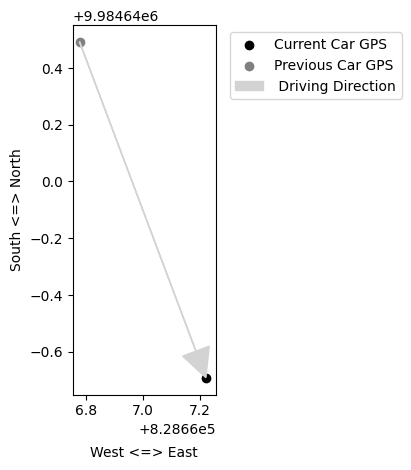

In [14]:
plt.scatter(utm_coord1[0], utm_coord1[1], color='black', label='Current Car GPS')  
plt.scatter(utm_coord0[0], utm_coord0[1], color='gray', label='Previous Car GPS')
plt.arrow(utm_coord0[0], utm_coord0[1], delta_east, delta_north, color='lightgray', label=" Driving Direction",
         head_width=0.1, head_length=0.1, length_includes_head=True)
plt.xlabel('West <=> East', labelpad=20)
plt.ylabel('South <=> North')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## 4. Compute Orthogonal line

In [15]:
orthogonal_slope = -delta_east / delta_north # = -Δx/Δy
orthogonal_slope

0.3762048703774055

In [16]:
orthogonal_b = utm_coord1[1] - (orthogonal_slope * utm_coord1[0])
orthogonal_b

9672890.66291339

In [17]:
def orthogonal_y(x):
    return orthogonal_slope*x + orthogonal_b

In [18]:
assert orthogonal_y(x=utm_coord1[0]) == utm_coord1[1], "Orthogonal line does not intersect driving point"

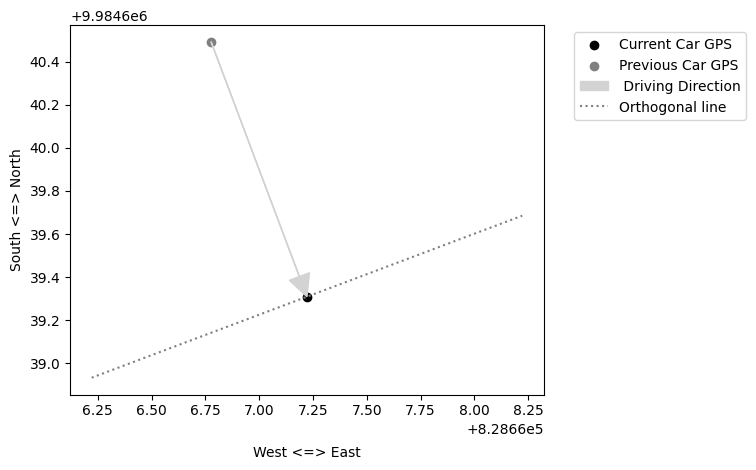

In [19]:
plt.scatter(utm_coord1[0], utm_coord1[1], color='black', label='Current Car GPS')  
plt.scatter(utm_coord0[0], utm_coord0[1], color='gray', label='Previous Car GPS')
plt.arrow(utm_coord0[0], utm_coord0[1], delta_east, delta_north, color='lightgray', label=" Driving Direction",
         head_width=0.1, head_length=0.1, length_includes_head=True)

offset_m = 1
orthogonal_xs = [utm_coord1[0] - offset_m, utm_coord1[0] + offset_m]
orthogonal_ys = [orthogonal_y(utm_coord1[0] - offset_m), orthogonal_y(utm_coord1[0] + offset_m)]
plt.plot(orthogonal_xs, orthogonal_ys, ":", color="gray", label="Orthogonal line")

plt.xlabel('West <=> East', labelpad=20)
plt.ylabel('South <=> North')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### 5. Figure out passenger direction

In [20]:
# Essential question? do we move East or West along orthogonal line? (EASTING positive or negative)

# For Left-hand-drive country (like above example), passenger side is on the left
# Left is 90 degrees counter clockwise (examples of ccw 90 degree: N->W, SSE->ENE) ccw: [[0, -1], [1, 0]]
# Conclusion: Easting is inversely correlated with Northing 

# For Right-hand-drive country, passenger side is on the right
# Right is 90 degrees clockwise (examples of cw 90 degree: N->E, SSE->WSW) cw rotation: [[0, 1], [-1, 0]]
# Conclusion: Easting is correlated with Northing

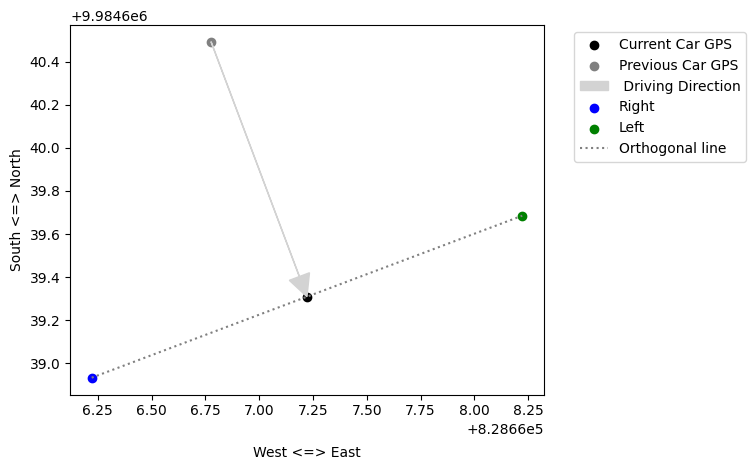

In [21]:
plt.scatter(utm_coord1[0], utm_coord1[1], color='black', label='Current Car GPS')  
plt.scatter(utm_coord0[0], utm_coord0[1], color='gray', label='Previous Car GPS')
plt.arrow(utm_coord0[0], utm_coord0[1], delta_east, delta_north, color='lightgray', label=" Driving Direction",
         head_width=0.1, head_length=0.1, length_includes_head=True)

offset = 1
north_sign = np.sign(delta_north)

right_point_easting = utm_coord1[0] + (north_sign * offset) # Correlation with Northing
right_point_northing = orthogonal_y(x=right_point_easting)

left_point_easting = utm_coord1[0] + (-1 * north_sign * offset) # Inverse correlation with Northing
left_point_northing = orthogonal_y(x=left_point_easting)

plt.scatter(right_point_easting , right_point_northing, color='blue', label='Right')
plt.scatter(left_point_easting, left_point_northing, color='green', label='Left')

orthogonal_xs = [utm_coord1[0] - offset, utm_coord1[0] + offset]
orthogonal_ys = [orthogonal_y(utm_coord1[0] - offset), orthogonal_y(utm_coord1[0] + offset)]
plt.plot(orthogonal_xs, orthogonal_ys, ":", color="gray", label="Orthogonal line")

plt.xlabel('West <=> East', labelpad=20)
plt.ylabel('South <=> North')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### 5. Figure out how to move point exactly 1 meter

In [22]:
# We created the left and right points above by using an x (easting) offset of 1 meter.
# However the actual distance the left/right point was moved is more than 1 meter as it includes a northing offset also.

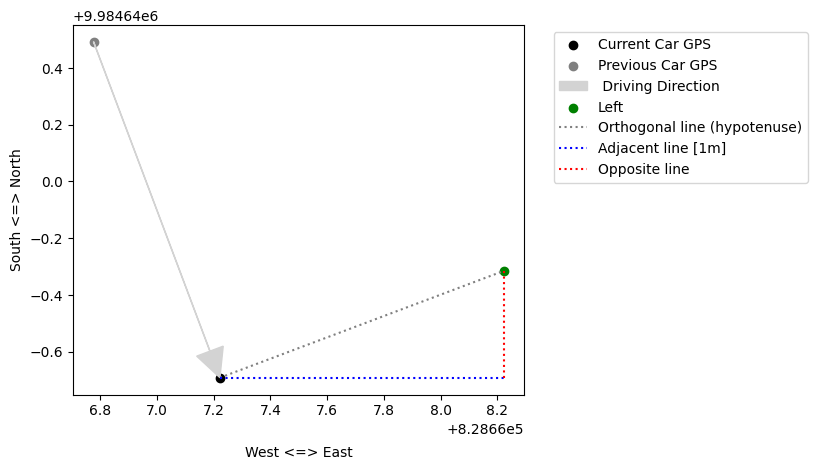

In [23]:
plt.scatter(utm_coord1[0], utm_coord1[1], color='black', label='Current Car GPS')  
plt.scatter(utm_coord0[0], utm_coord0[1], color='gray', label='Previous Car GPS')
plt.arrow(utm_coord0[0], utm_coord0[1], delta_east, delta_north, color='lightgray', label=" Driving Direction",
         head_width=0.1, head_length=0.1, length_includes_head=True)

offset = 1
north_sign = np.sign(delta_north)

x2 = utm_coord1[0] + (-1 * north_sign * offset) # Inverse correlation with Northing
y2 = orthogonal_y(x=x2)
plt.scatter(x2, y2, color='green', label='Left')

x1, y1 = utm_coord1[0], utm_coord1[1]

plt.plot([x1, x2], [y1, y2], ":", color="gray", label="Orthogonal line (hypotenuse)")
plt.plot([x1, x2], [y1, y1], ":", color="blue", label="Adjacent line [1m]")
plt.plot([x2, x2], [y1, y2], ":", color="red", label="Opposite line")

plt.xlabel('West <=> East', labelpad=20)
plt.ylabel('South <=> North')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [24]:
# toa
adjacent = x2 - x1
opposite = y2 - y1
angle = math.atan(opposite / adjacent)

# cos(angle) = adjacent / hypotenuse
# then adjacent = hypothenues * cos(angle)
real_1m_offset = 1 * math.cos(angle)
real_1m_offset

0.9359579022144625

In [35]:
20 * math.cos(angle)

18.71915804428925

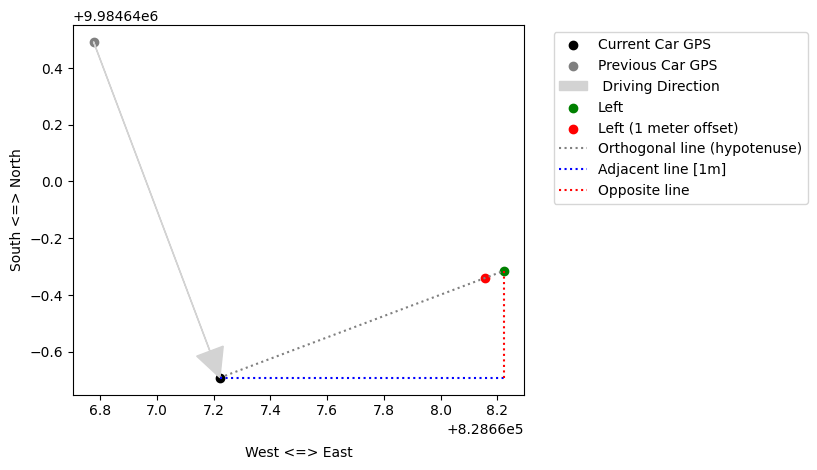

In [25]:
plt.scatter(utm_coord1[0], utm_coord1[1], color='black', label='Current Car GPS')  
plt.scatter(utm_coord0[0], utm_coord0[1], color='gray', label='Previous Car GPS')
plt.arrow(utm_coord0[0], utm_coord0[1], delta_east, delta_north, color='lightgray', label=" Driving Direction",
         head_width=0.1, head_length=0.1, length_includes_head=True)

north_sign = np.sign(delta_north)
offset = 1
x2 = utm_coord1[0] + (-1 * north_sign * offset) # Inverse correlation with Northing
y2 = orthogonal_y(x=x2)
plt.scatter(x2, y2, color='green', label='Left')

x3 = utm_coord1[0] + (-1 * north_sign * real_1m_offset) 
y3 = orthogonal_y(x=x3)
plt.scatter(x3, y3, color='red', label='Left (1 meter offset)')

x1, y1 = utm_coord1[0], utm_coord1[1]

plt.plot([x1, x2], [y1, y2], ":", color="gray", label="Orthogonal line (hypotenuse)")
plt.plot([x1, x2], [y1, y1], ":", color="blue", label="Adjacent line [1m]")
plt.plot([x2, x2], [y1, y2], ":", color="red", label="Opposite line")

plt.xlabel('West <=> East', labelpad=20)
plt.ylabel('South <=> North')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### 6. Putting it all together

In [37]:
def generate_orthogonal_offset_point_utm(utm_coord0, utm_coord1, is_right_hand_drive=True, meters=1):
    delta_east = utm_coord1[0] - utm_coord0[0]
    delta_north = utm_coord1[1] - utm_coord0[1]

    # Offset for meters change in offset point distance 
    x_offset = meters * math.cos(math.atan(delta_east / delta_north))

    # Direction of offset
    x_direction = np.sign(delta_north) if is_right_hand_drive else -np.sign(delta_north)
    x_offset *= x_direction
        
    orthogonal_slope = -delta_east / delta_north
    orthogonal_b = utm_coord1[1] - (orthogonal_slope * utm_coord1[0])
    orthogonal_y = lambda x: orthogonal_slope*x + orthogonal_b

    field_point_x = utm_coord1[0] + x_offset
    field_point_y = orthogonal_y(field_point_x)

    return field_point_x, field_point_y

### 7. Compute 5, 10, 15 meter offset on passenger side

In [38]:
x5, y5 = generate_orthogonal_offset_point_utm(utm_coord0, utm_coord1, is_right_hand_drive=False, meters=5)
x10, y10 = generate_orthogonal_offset_point_utm(utm_coord0, utm_coord1, is_right_hand_drive=False, meters=10)
x15, y15 = generate_orthogonal_offset_point_utm(utm_coord0, utm_coord1, is_right_hand_drive=False, meters=15)
x20, y20 = generate_orthogonal_offset_point_utm(utm_coord0, utm_coord1, is_right_hand_drive=False, meters=20)

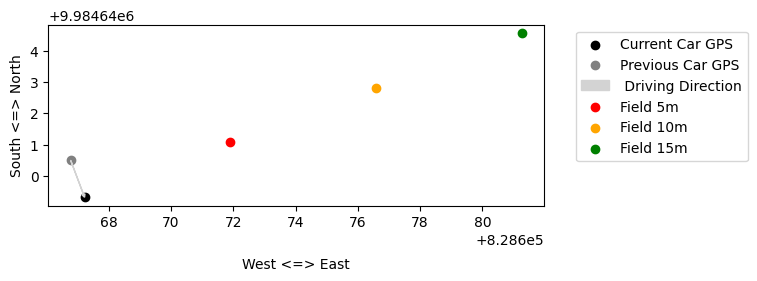

In [41]:
plt.scatter(utm_coord1[0], utm_coord1[1], color='black', label='Current Car GPS')  
plt.scatter(utm_coord0[0], utm_coord0[1], color='gray', label='Previous Car GPS')
plt.arrow(utm_coord0[0], utm_coord0[1], delta_east, delta_north, color='lightgray', label=" Driving Direction",
         head_width=0.1, head_length=0.1, length_includes_head=True)


plt.scatter(x5, y5, color='red', label='Field 5m')
plt.scatter(x10, y10, color='orange', label='Field 10m')
plt.scatter(x15, y15, color='green', label='Field 15m')

plt.xlabel('West <=> East', labelpad=20)
plt.ylabel('South <=> North')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### 8. Deciding on distance offset

In the above example an offset of 5, 10, and 15 meters is used to get the field coordiante from the GoPro coordinate.
It is unclear which one will give a more accurate representation of the field.

#### Considering downstream usage

One thing we do know is that the generated field points will be used to get Earth observation data (such as Sentinel-2).
Sentinel-2 data is captured in pixels (RGB data in 10 meter pixels). 
So for a field coordinate we will fetch a 10x10 meter pixel of data.

We know that S2 L1C and L2A are projected onto UTM, from: https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-2/data-products
> For Level-1C and Level-2A, the granules, also called tiles, are 110x110 km2 ortho-images in UTM/WGS84 projection

So S2 pixels should translate directly to 10 meter squares in UTM.

Therefore if we simply round down the UTM coordinates to the nearest 10th we get a point that represents the South West (bottom left) corner of a Sentinel-2 pixel.

If we add 5m to the x,y components of the bottom left coordinate we should get the pixel centroid.

If we add 10m to the x,y components of the bottom left coordinate we should get the pixel top right corner.


### 8.1 Verifying Sentinel-2 RGB Pixels Map to UTM 10 meter intervals

In [42]:
# Verifying above assumption, get pixel bottom left point
pixel_coord_utm = utm_coord1[0] // 10 * 10, utm_coord1[1] // 10 * 10

In [43]:
# Convert to latlons
pixel_bottom_left_latlon = utm.to_latlon(pixel_coord_utm[0], pixel_coord_utm[1], utm_coord0[2], utm_coord0[3])
pixel_centroid_latlon = utm.to_latlon(pixel_coord_utm[0] + 5, pixel_coord_utm[1] + 5, utm_coord0[2], utm_coord0[3])
pixel_top_right_latlon = utm.to_latlon(pixel_coord_utm[0] + 10, pixel_coord_utm[1] + 10, utm_coord0[2], utm_coord0[3])

In [44]:
# GEE code
print(
f"""
// Get and S2 image
var S2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
var S2_Jan = S2.filterDate("2021-01-01", "2021-02-01").mosaic()
var visualization = {{min: 0.0, max: 3000, bands: ['B4', 'B3', 'B2']}};
Map.addLayer(S2_Jan, visualization, "Sentinel-2 Jan")

var roadPoint = ee.Geometry.Point([{coord1[1]}, {coord1[0]}])

Map.addLayer(roadPoint, {{color: "green"}}, "Road")
Map.addLayer(ee.Geometry.Point([{pixel_bottom_left_latlon[1]}, {pixel_bottom_left_latlon[0]}]), {{color: "yellow"}}, "Bottom Left")
Map.addLayer(ee.Geometry.Point([{pixel_centroid_latlon[1]}, {pixel_centroid_latlon[0]}]), {{color: "red"}}, "Centroid")
Map.addLayer(ee.Geometry.Point([{pixel_top_right_latlon[1]}, {pixel_top_right_latlon[0]}]), {{color: "orange"}}, "Top Right")

Map.centerObject(roadPoint)

""")


// Get and S2 image
var S2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
var S2_Jan = S2.filterDate("2021-01-01", "2021-02-01").mosaic()
var visualization = {min: 0.0, max: 3000, bands: ['B4', 'B3', 'B2']};
Map.addLayer(S2_Jan, visualization, "Sentinel-2 Jan")

var roadPoint = ee.Geometry.Point([35.952341799972224, -0.1387873])

Map.addLayer(roadPoint, {color: "green"}, "Road")
Map.addLayer(ee.Geometry.Point([35.952276995685764, -0.13887131400823968]), {color: "yellow"}, "Bottom Left")
Map.addLayer(ee.Geometry.Point([35.95232186390592, -0.13882613223247733]), {color: "red"}, "Centroid")
Map.addLayer(ee.Geometry.Point([35.952366732125924, -0.1387809504603011]), {color: "orange"}, "Top Right")

Map.centerObject(roadPoint)




Verified with GoPro coordinate and prior coordinate. 

- Road Point: Green
- Bottom Left: Yellow
- Centroid: Red
- Top Right: Orange 

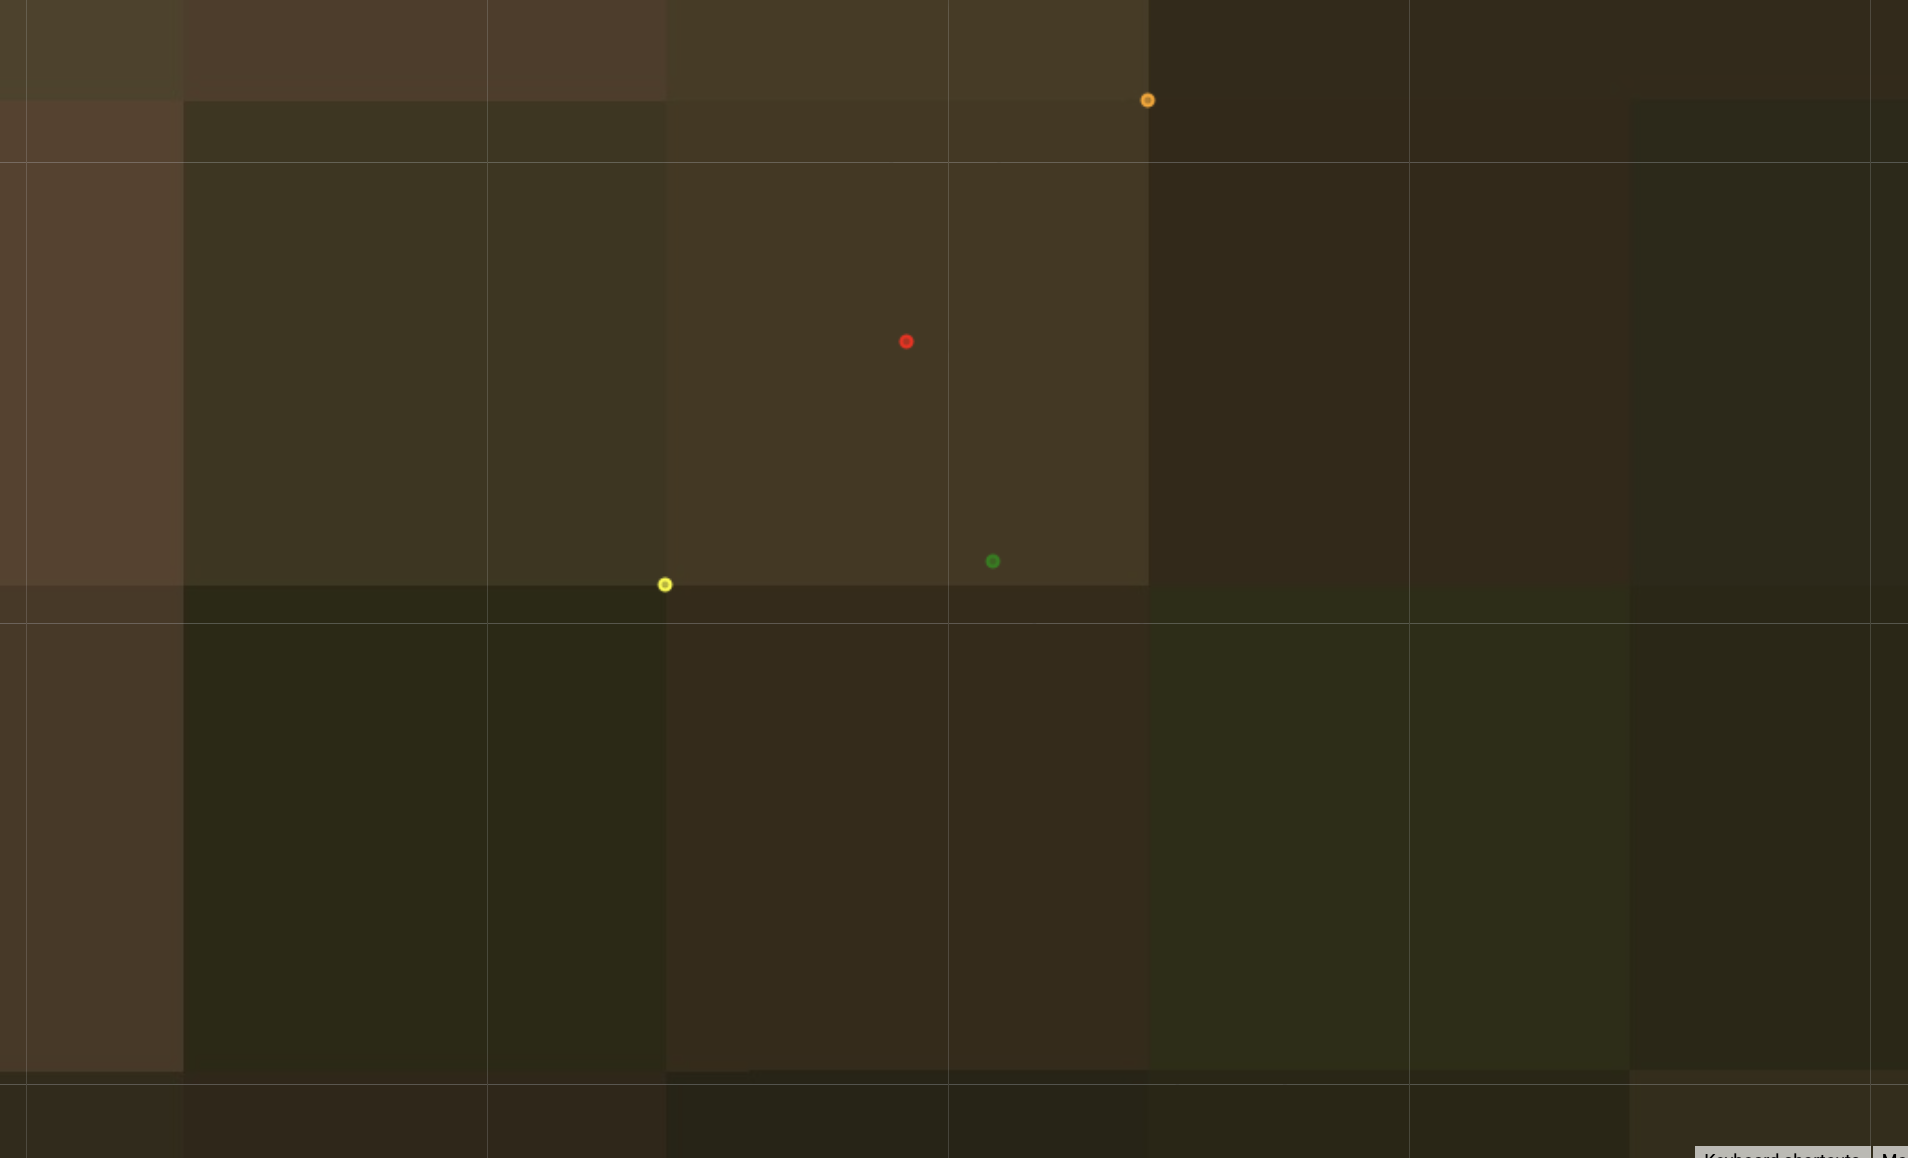
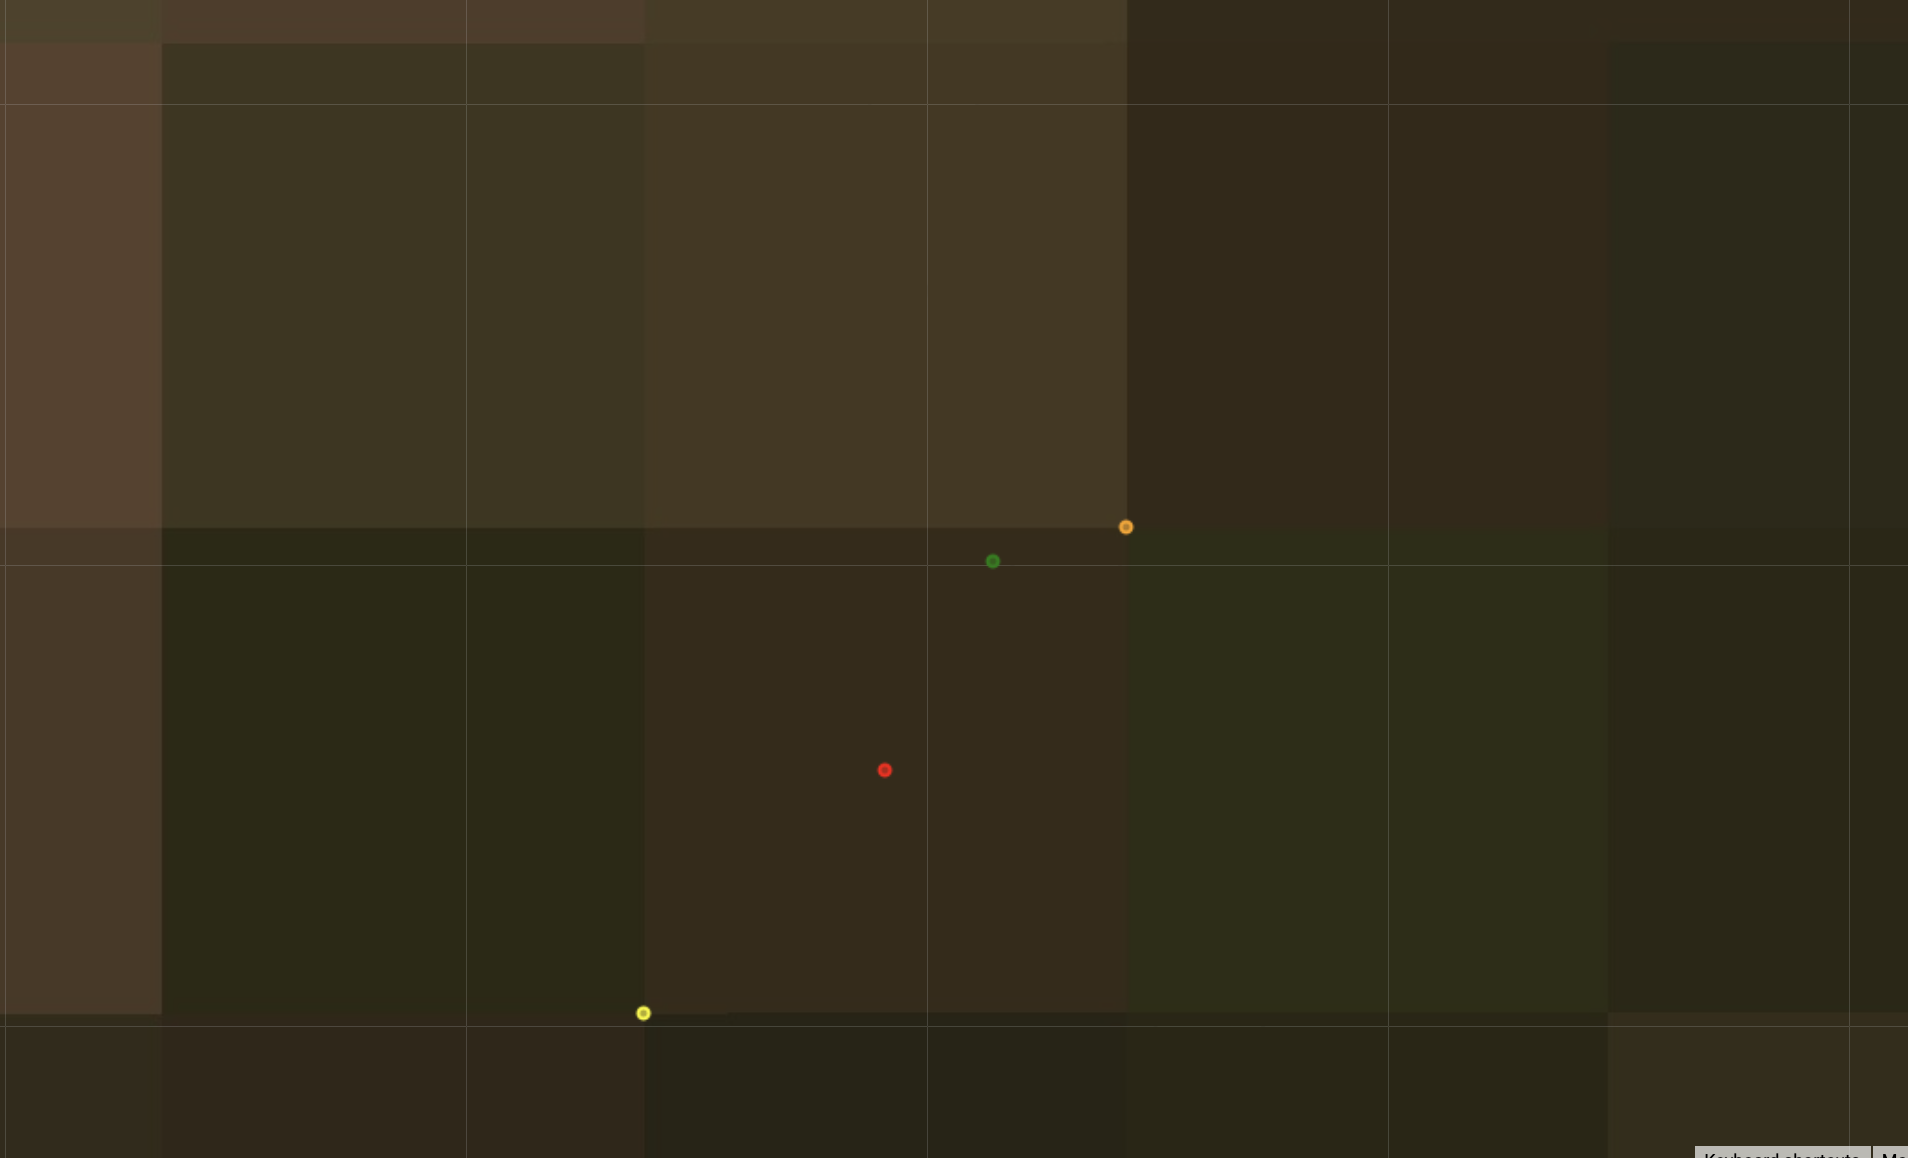

## 8.2 Deciding on distance offset considering 10 meter pixels

The GoPro image coordinate falls into 10x10 meter pixel of data that we can call the road pixel.

The pixel that represents the field should not be the road pixel.

Therefore the field coordinate should fall outside of the road pixel.

Using an offset over 14.14 m (diagonal distance of pixel) ensures the field point falls outside the road pixel.

## 8.3 Deciding on a distance offset considering field size

A representative 10x10m field pixel should fall completely within a field.

The field size can be a useful heuristic to help maximize this probability.

JECAM's definition of cropland is
> A piece of land of minimum 0.25 ha (width 30m) that is sowed/planted and harvestable at least once within 12 months.

So from the edge of a minimum size field to its center is 15 meters.

However, in most cases the road is not directly adjacent to the field. A buffer may exist for runoff or other purposes.

Therefore,

`distance_offset = field_buffer + (min_field_width / 2)`

These values can be modified on a per region basis. 

But for simplicity we will use JECAM's crop definition for field size and a buffer of 5 meters.

`distance_offset = 5 + (30 / 2) = 20 meters`

This is over 14.14 meters so it satisfies the different pixel criteria.


### Bonus: Non-crop pixel

The road point can be used as a non-crop point.

In [45]:
x20, y20 = generate_orthogonal_offset_point_utm(utm_coord0, utm_coord1, is_right_hand_drive=False, meters=20)

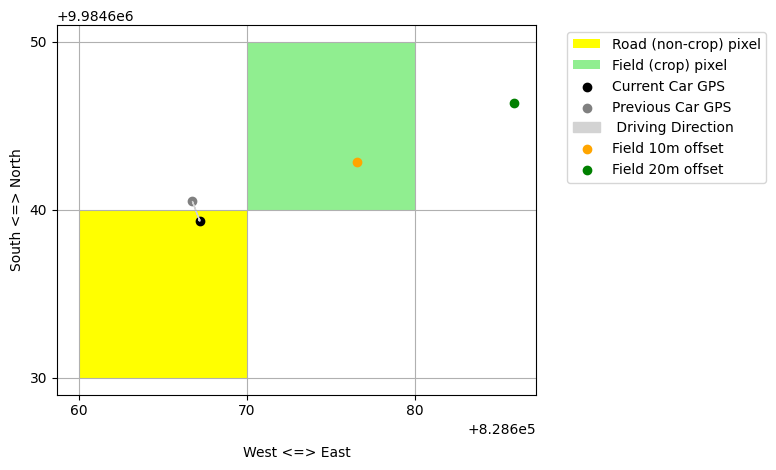

In [46]:
round_to_pixel = lambda x: x//10 * 10

# Bottom left
road_pixel = round_to_pixel(utm_coord1[0]), round_to_pixel(utm_coord1[1])
field_pixel = round_to_pixel(x10), round_to_pixel(y10)

ax = plt.gca()
road_square = patches.Rectangle(road_pixel, 10, 10, facecolor='yellow', label="Road (non-crop) pixel")
crop_square = patches.Rectangle(field_pixel, 10, 10, facecolor='lightgreen', label="Field (crop) pixel")

ax.add_patch(road_square)
ax.add_patch(crop_square)

plt.scatter(utm_coord1[0], utm_coord1[1], color='black', label='Current Car GPS')  
plt.scatter(utm_coord0[0], utm_coord0[1], color='gray', label='Previous Car GPS')
plt.arrow(utm_coord0[0], utm_coord0[1], delta_east, delta_north, color='lightgray', label=" Driving Direction",
         head_width=0.1, head_length=0.1, length_includes_head=True)

plt.scatter(x10, y10, color='orange', label='Field 10m offset') 
plt.scatter(x20, y20, color='green', label='Field 20m offset')  

plt.xlabel('West <=> East', labelpad=20)
plt.ylabel('South <=> North')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_aspect('equal', adjustable='box')

utm_x_rounded10 = round(utm_coord1[0], -1)
utm_y_rounded10 = round(utm_coord1[1], -1)

ax.set_xticks([utm_x_rounded10 + i for i in [-10,0,10]])
ax.set_yticks([utm_y_rounded10 + i for i in [-10,0,10]])

plt.grid()
plt.show()

### 9. Dealing with points in the same field - Clustering

The GoPro is set to take images at an interval of 0.5 seconds

Traveling at 10 km/h => 10,000m / 3600s => ~2.8 m/s, image / 1.4 m

20 km/h => image / 2.8 m

30 km/h => image / 4.2 m

Let's consider 20 km/h as an average speed, then a 30 meter field adjacent to the road will have 30/2.8 = 10-11 photos.

Some photos may be blurry or obstructed, or not capture the crop completely so it is good to have redundancy here.

However in this example, all 10-11 photos represent the same field. 

A larger field, e.g. 100 m adjacent to the road, may have over 30 photos representing it.

#### Considering downstream usage 

We come back to the Sentinel-2 constraint of a 10x10 meter pixel. 

### 9.1 Cluster by 10 meter pixel

Field points that fall within the same pixel will be used to fetch the same Earth observation data.

Therefore they can be clustered together.

This can be done by rounding each field coordinate to its pixel centroid.

This can also be done with the non-crop road points to generate non-crop coordinates.

This sort of clustering will reduce a 30 meter field to 3-4 field points depending on how 10m UTM pixels align with the field.

A 100 meter field will be reduced to around 10 points given the above assumptions.

#### Is that sufficient clustering?

Yes, 20 meter clustering can also be explored but that will add some complexity.


### 10. Create lat/lon version

In [47]:
floor10 = lambda x: x//10 * 10
to_pixel_centroid = lambda coord: (floor10(coord[0]) + 5, floor10(coord[1]) + 5)

def generate_offset_point_wgs84(coord0, coord1, is_right_hand_drive=True, meters=20, round_to_centroid=True):
    utm_coord0 = utm.from_latlon(coord0[0], coord0[1])
    utm_coord1 = utm.from_latlon(coord1[0], coord1[1])

    for i, zone_type in [(2, "number"), (3, "letter")]:
        if utm_coord1[i] != utm_coord0[i]:
            print(utm_coord0)
            print(utm_coord1)
            raise ValueError(f"UTM Zone {zone_type} mismatch: {utm_coord0[i]} and {utm_coord1[i]}")
    
    
    delta_east = utm_coord1[0] - utm_coord0[0]
    delta_north = utm_coord1[1] - utm_coord0[1]

    # Offset for meters change in offset point distance 
    x_offset = meters * math.cos(math.atan(delta_north / delta_east))

    # Direction of offset
    x_direction = np.sign(delta_north) if is_right_hand_drive else -np.sign(delta_north)
    x_offset *= x_direction
        
    orthogonal_slope = -delta_east / delta_north
    orthogonal_b = utm_coord1[1] - (orthogonal_slope * utm_coord1[0])
    orthogonal_y = lambda x: orthogonal_slope*x + orthogonal_b

    field_point_x = utm_coord1[0] + x_offset
    field_point_y = orthogonal_y(field_point_x)

    if round_to_centroid:
        field_point_x, field_point_y  = to_pixel_centroid((field_point_x, field_point_y))
        

    return utm.to_latlon(field_point_x, field_point_y, utm_coord1[2], utm_coord1[3])

def road_pixel_centroid(coord):
    utm_coord = utm.from_latlon(coord[0], coord[1])
    utm_pixel_centroid = to_pixel_centroid(utm_coord)
    return utm.to_latlon(*utm_pixel_centroid, utm_coord[2], utm_coord[3])
    

### 9. Verify Lat/lon version

In [48]:
from pygeotile.tile import Point, Tile
import cv2
import wget

In [50]:
BING_URL = "http://ecn.t0.tiles.virtualearth.net/tiles"
ZOOM = 18

In [51]:
t = Tile.for_latitude_longitude(coord1[0], coord1[1], ZOOM)
bing_url = f"http://ecn.t0.tiles.virtualearth.net/tiles/a{t.quad_tree}.jpeg?g=14009"

In [87]:
!rm bing_img.jpeg
wget.download(bing_url, "bing_img.jpeg")

100% [..........................................................] 12244 / 12244

'bing_img.jpeg'

In [53]:
latlon_crop = generate_offset_point_wgs84(coord0, coord1, is_right_hand_drive=False)

In [54]:
latlon_noncrop = road_pixel_centroid(coord1)

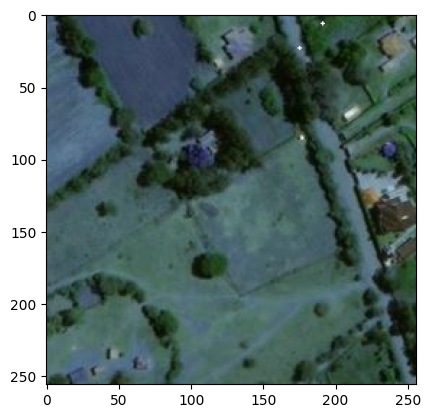

In [55]:
def coord_to_xy(coord):
    pixel_x, pixel_y = Point(coord[0], coord[1]).pixels(ZOOM)
    return (pixel_x % 256), (pixel_y % 256)
    
img = cv2.imread("bing_img.jpeg", cv2.IMREAD_COLOR)
img = cv2.circle(img, coord_to_xy(latlon_noncrop), 1, (255, 255, 255), -1)
img = cv2.circle(img, coord_to_xy(latlon_crop), 1, (255, 255, 255), -1)

plt.imshow(img)
plt.show()